TOSP Code Inappropriate Claims Detection

Using K-Means and DBSCAN clustering


In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import time

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

1. Load and Explore Data

Reads the TOSP codes dataset from a CSV file.
Displays the first few rows and dataset details.
Lists available columns.

In [62]:
# Load your dataset
df_tosp = pd.read_csv("/content/sample_data/combined_dataset.csv")

# Display summary information
print("TOSP Dataset Preview:")
print(df_tosp.head())
print("\nDataset Information:")
print(df_tosp.info())
print("\nColumn Names:", df_tosp.columns.tolist())

TOSP Dataset Preview:
   S/N    Code                                        Description Table  \
0    1  SA700B     BOTULINUM TOXIN THERAPY FOR MOVEMENT DISORDERS   MSP   
1    2  SA701B  BREAST, DUCTAL LESIONS, MICRODOCHECTOMY (BILAT...    3A   
2    3  SA702B  BREAST, DUCTAL LESIONS, MICRODOCHECTOMY (UNILA...    2C   
3    4  SA704B  BREAST, LUMPS, IMAGING GUIDED VACUUM ASSISTED ...    2B   
4    5  SA705B  BREAST, LUMP (REMOVAL) WITH PARENCHYMAL FLAP C...    4A   

      Classification  
0           Existing  
1           Existing  
2           Existing  
3           Existing  
4  Descriptor Change  

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2363 entries, 0 to 2362
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   S/N             2363 non-null   int64 
 1   Code            2363 non-null   object
 2   Description     2363 non-null   object
 3   Table           2363 non-null   obje

2. Generate Mock Claims

It is used for testing clustering
- Extracts unique procedure code from dataset
- Bilateral/Unilateral Procedures
- Find codes with similar description to simulate inapproapriate code pairings

In [63]:
# Since we don't have actual claims data, we'll create mock claimsthat simulate potential inappropriate claims

def generate_mock_claims(df_tosp, num_claims=1000):
    """
    Generate mock claims data for testing clustering algorithms.
    Some claims will intentionally have paired codes that might be inappropriate.
    """
    np.random.seed(42)  # For reproducibility

    # Get list of all codes
    all_codes = df_tosp['Code'].unique().tolist()

    # Extract potential patterns for creating inappropriate pairs
    bilateral_codes = df_tosp[df_tosp['Description'].str.contains('BILATERAL', case=False, na=False)]['Code'].tolist()
    unilateral_codes = df_tosp[df_tosp['Description'].str.contains('UNILATERAL', case=False, na=False)]['Code'].tolist()

     # Create a mapping of similar codes (codes with similar descriptions)
    similar_codes = {}
    for code in all_codes:
        desc = df_tosp[df_tosp['Code'] == code]['Description'].values[0]
        # Find codes with similar descriptions
        # Escape special characters in the description for regex
        search_pattern = '|'.join([re.escape(word) for word in desc.split()[:3]])
        similar = df_tosp[df_tosp['Description'].str.contains(
            search_pattern, case=False, na=False)]['Code'].tolist()
        # Remove the code itself
        if code in similar:
            similar.remove(code)
        if similar:
            similar_codes[code] = similar

    # Create claims
    claims = []

    for i in range(num_claims):
        # Determine if this will be a claim with a single code or multiple codes
        is_multi_code = np.random.choice([True, False], p=[0.3, 0.7])

        if is_multi_code:
            # Create a potentially inappropriate claim with multiple codes
            primary_code = np.random.choice(all_codes)

            # 50% chance of using a similar code if available
            if primary_code in similar_codes and np.random.random() < 0.5:
                secondary_code = np.random.choice(similar_codes[primary_code])
            else:
                # Otherwise, just pick a random second code
                secondary_code = np.random.choice(all_codes)
                while secondary_code == primary_code:
                    secondary_code = np.random.choice(all_codes)

            codes = [primary_code, secondary_code]
        else:
            # Single code claim
            codes = [np.random.choice(all_codes)]

        # Get descriptions for these codes
        descriptions = []
        tables = []
        for code in codes:
            code_info = df_tosp[df_tosp['Code'] == code]
            descriptions.append(code_info['Description'].values[0])
            tables.append(code_info['Table'].values[0])

        # Create the claim
        claim = {
            'claim_id': f'CLAIM{i+1:04d}',
            'codes': ','.join(codes),
            'descriptions': ' | '.join(descriptions),
            'tables': ','.join(tables),
            'num_codes': len(codes)
        }
        claims.append(claim)

    return pd.DataFrame(claims)

# Generate mock claims
claims_df = generate_mock_claims(df_tosp, num_claims=1000)
print("\nGenerated Claims Data Preview:")
print(claims_df.head())


Generated Claims Data Preview:
    claim_id          codes  \
0  CLAIM0001         SD733A   
1  CLAIM0002  SF719A,SI700C   
2  CLAIM0003         SF708G   
3  CLAIM0004  SL846E,SF815P   
4  CLAIM0005         SC801D   

                                        descriptions tables  num_codes  
0   ARTERY-PSEUDOANEURYSM, EXCISION AND PATCH REPAIR     5A          1  
1  ANUS, ANO-RECTAL MALFORMATION, ANORECTOPLASTY ...  5C,5B          2  
2  RADICAL CHOLEDOCHECTOMY WITH LIVER RESECTION (...     7A          1  
3  EYELIDS, TUMOR, SHAVING EXCISION | PAROTID, TU...  1A,7B          2  
4  DIAPHRAGM, TUMOR, EXCISION WITH WEDGE RESECTIO...     6B          1  


3. Feature Engineering
- Extracts important features from claims to help clustering.

In [64]:
# 3. Feature Engineering

def preprocess_text(text):
    """Preprocess text by lowercasing, removing special characters, and lemmatizing."""
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Convert to lowercase and remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', str(text).lower())

    # Tokenize, remove stopwords, and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]

    return ' '.join(tokens)

def extract_features(claims_df, df_tosp):
    """Extract features from claims data for clustering."""
    # Create features for each claim
    features = []

    for _, claim in claims_df.iterrows():
        claim_codes = claim['codes'].split(',')

        # Get the descriptions for analysis
        preprocessed_desc = preprocess_text(claim['descriptions'])

        # Check for bilateral/unilateral procedures
        is_bilateral = 'bilateral' in preprocessed_desc
        is_unilateral = 'unilateral' in preprocessed_desc

        # Check if codes are from the same table
        tables = claim['tables'].split(',')
        same_table = len(set(tables)) == 1

        # Count number of codes
        num_codes = claim['num_codes']

        # Check if descriptions have high similarity
        # This would be a signal for potentially redundant codes
        desc_similarity = 1.0  # Default for single code claims
        if num_codes > 1:
            # Simple approach: calculate overlap in words between descriptions
            descriptions = claim['descriptions'].split(' | ')
            words1 = set(descriptions[0].lower().split())
            words2 = set(descriptions[1].lower().split())
            if words1 and words2:  # Avoid division by zero
                overlap = len(words1.intersection(words2))
                total = len(words1.union(words2))
                desc_similarity = overlap / total

        features.append({
            'claim_id': claim['claim_id'],
            'preprocessed_desc': preprocessed_desc,
            'num_codes': num_codes,
            'is_bilateral': int(is_bilateral),
            'is_unilateral': int(is_unilateral),
            'same_table': int(same_table),
            'desc_similarity': desc_similarity,
            'original_codes': claim['codes']
        })

    return pd.DataFrame(features)

# Extract features
features_df = extract_features(claims_df, df_tosp)
print("\nExtracted Features Preview:")
print(features_df.head())


Extracted Features Preview:
    claim_id                                  preprocessed_desc  num_codes  \
0  CLAIM0001         arterypseudoaneurysm excision patch repair          1   
1  CLAIM0002  anus anorectal malformation anorectoplasty mi ...          2   
2  CLAIM0003  radical choledochectomy liver resection less s...          1   
3  CLAIM0004  eyelid tumor shaving excision parotid tumor to...          2   
4  CLAIM0005      diaphragm tumor excision wedge resection lung          1   

   is_bilateral  is_unilateral  same_table  desc_similarity original_codes  
0             0              0           1         1.000000         SD733A  
1             0              0           0         0.000000  SF719A,SI700C  
2             0              0           1         1.000000         SF708G  
3             0              0           0         0.071429  SL846E,SF815P  
4             0              0           1         1.000000         SC801D  


4. Convert Text to Numerical Features
- Uses TF-IDF vectorization to convert descriptions into numerical vectors.
- Merges text features with numerical features.

- Feature Scaling


In [76]:
# Use TF-IDF to convert text descriptions to numerical features
vectorizer = TfidfVectorizer(max_features=100)
text_features = vectorizer.fit_transform(features_df['preprocessed_desc'])

# Get feature names for later analysis
feature_names = vectorizer.get_feature_names_out()

# Combine text features with other numerical features
numerical_features = features_df[['num_codes', 'is_bilateral', 'is_unilateral',
                                'same_table', 'desc_similarity']].values
text_features_dense = text_features.toarray()
combined_features = np.hstack((text_features_dense, numerical_features))

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(combined_features)


5. K-Means Clustering
- Finding Optimal k (Number of Clusters)
- Elbow Method: Finds k where adding more clusters does not significantly reduce inertia.
- Silhouette Score: Measures how well-separated clusters are.
- Apply K-Means

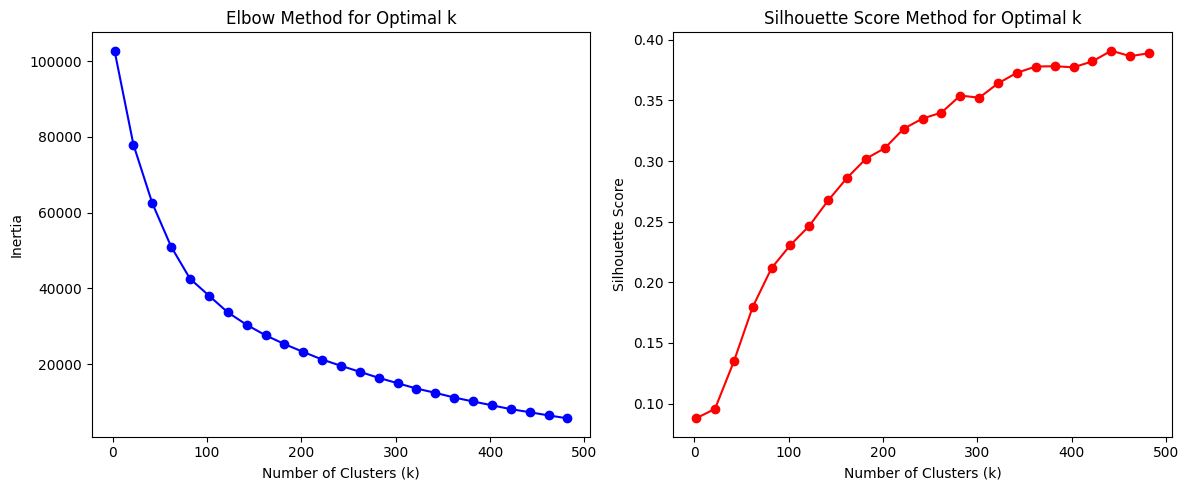

Optimal k based on silhouette score: 442
K-Means execution time: 4.0989 seconds


In [92]:
def find_optimal_k(scaled_features, max_k=500, step_size=20):
    """Find optimal number of clusters using elbow method and silhouette score."""
    inertia = [] #SSE
    silhouette_scores = []
    k_values = list(range(2, max_k + 1, step_size))  # Correct k values

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(scaled_features)
        inertia.append(kmeans.inertia_)

        # Calculate silhouette score
        labels = kmeans.labels_
        silhouette_avg = silhouette_score(scaled_features, labels)
        silhouette_scores.append(silhouette_avg)

    # Plot elbow method
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(k_values, inertia, 'bo-')  # Correct x-values
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')

    plt.subplot(1, 2, 2)
    plt.plot(k_values, silhouette_scores, 'ro-')  # Correct x-values
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score Method for Optimal k')

    plt.tight_layout()
    plt.show()

    # Find the optimal k based on silhouette score
    best_index = np.argmax(silhouette_scores)  # Find the index
    optimal_k = k_values[best_index]  # Get corresponding k value

    print(f"Optimal k based on silhouette score: {optimal_k}")

    return optimal_k, inertia, silhouette_scores

# Find optimal k
optimal_k, inertia, silhouette_scores = find_optimal_k(scaled_features)

# Train K-Means with optimal k
start_time = time.time()
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(scaled_features)
kmeans_time = time.time() - start_time

print(f"K-Means execution time: {kmeans_time:.4f} seconds")

DBSCAN Clustering (Detecting Anomalies)

- Finding Optimal Epsilon (eps)

- Apply DBSCAN


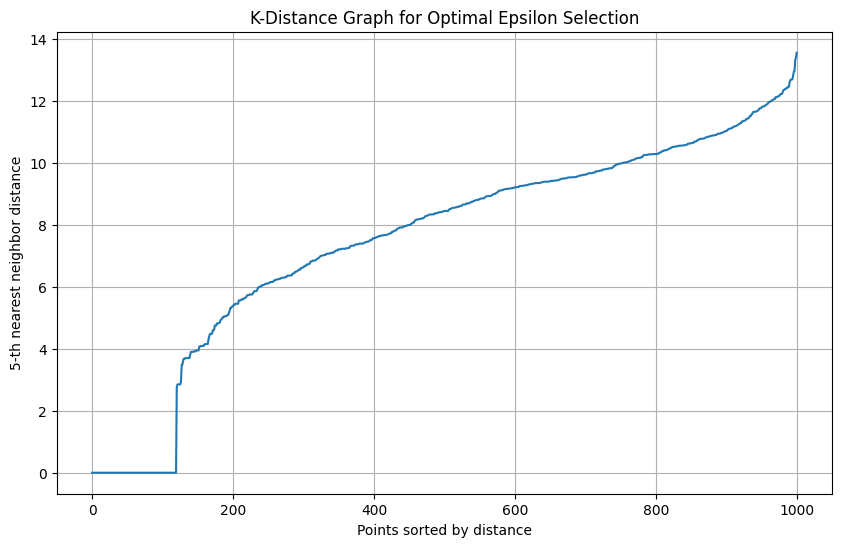

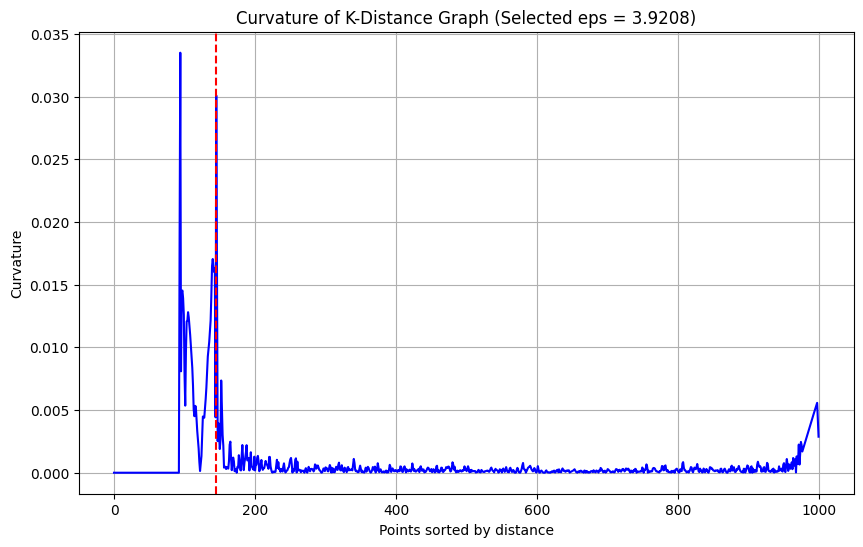

Optimal epsilon for DBSCAN: 3.9208
DBSCAN execution time: 0.0212 seconds


In [67]:
def find_optimal_eps(scaled_features, k=5):
    """Find optimal epsilon value for DBSCAN using k-distance graph."""
    from sklearn.neighbors import NearestNeighbors

    # Calculate distances
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(scaled_features)
    distances, indices = neighbors_fit.kneighbors(scaled_features)

    # Sort distances
    distances = np.sort(distances[:, k-1])

    # Plot k-distance graph
    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.xlabel('Points sorted by distance')
    plt.ylabel(f'{k}-th nearest neighbor distance')
    plt.title('K-Distance Graph for Optimal Epsilon Selection')
    plt.grid(True)
    plt.show()

    # Try to find the "elbow" in the distance graph
    # Simple approach: find the point with maximum curvature
    # (For a more robust approach, you might want to try multiple eps values)
    x = np.arange(len(distances))
    #from scipy.interpolate import interp1d # This import is not used
    from scipy.signal import savgol_filter

    # Smooth the curve to find the elbow more easily
    y_smooth = savgol_filter(distances, window_length=min(51, len(distances)-1), polyorder=3)

    # Calculate the curvature (approximate)
    dy_dx = np.gradient(y_smooth)
    d2y_dx2 = np.gradient(dy_dx)
    curvature = np.abs(d2y_dx2) / (1 + dy_dx**2)**(3/2)

    # Find point of maximum curvature (avoiding the endpoints)
    start_idx = int(len(curvature) * 0.1)  # Skip the first 10%
    end_idx = int(len(curvature) * 0.9)    # Skip the last 10%
    max_curv_idx = start_idx + np.argmax(curvature[start_idx:end_idx])

    optimal_eps = distances[max_curv_idx]

    # Plot the curvature and the selected eps
    plt.figure(figsize=(10, 6))
    plt.plot(x, curvature, 'b-')
    plt.axvline(x=max_curv_idx, color='r', linestyle='--')
    plt.title(f'Curvature of K-Distance Graph (Selected eps = {optimal_eps:.4f})')
    plt.xlabel('Points sorted by distance')
    plt.ylabel('Curvature')
    plt.grid(True)
    plt.show()

    return optimal_eps

# Find optimal eps
optimal_eps = find_optimal_eps(scaled_features)
print(f"Optimal epsilon for DBSCAN: {optimal_eps:.4f}")

# Train DBSCAN with optimal parameters
start_time = time.time()
dbscan = DBSCAN(eps=optimal_eps, min_samples=5)
dbscan_labels = dbscan.fit_predict(scaled_features)
dbscan_time = time.time() - start_time
print(f"DBSCAN execution time: {dbscan_time:.4f} seconds")

Evaluation and Comparison between two classical algorithm

In [68]:
def evaluate_clustering(features, kmeans_labels, dbscan_labels):
    """Evaluate and compare clustering results."""
    # Count number of clusters
    kmeans_clusters = len(set(kmeans_labels)) - (1 if -1 in kmeans_labels else 0)
    dbscan_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)

    # Calculate silhouette scores
    kmeans_silhouette = silhouette_score(features, kmeans_labels) if kmeans_clusters > 1 else 0

    # For DBSCAN, compute silhouette only on non-noise points
    if dbscan_clusters > 1 and -1 in dbscan_labels:
        # Filter out noise points
        non_noise_mask = dbscan_labels != -1
        if np.sum(non_noise_mask) > 1:  # Need at least 2 points
            dbscan_silhouette = silhouette_score(features[non_noise_mask],
                                               dbscan_labels[non_noise_mask])
        else:
            dbscan_silhouette = 0
    elif dbscan_clusters > 1:
        dbscan_silhouette = silhouette_score(features, dbscan_labels)
    else:
        dbscan_silhouette = 0

    # Print results
    print("\nClustering Evaluation:")
    print("\nK-Means Results:")
    print(f"Number of clusters: {kmeans_clusters}")
    print(f"Silhouette Score: {kmeans_silhouette:.4f}")
    print(f"Execution Time: {kmeans_time:.4f} seconds")

    print("\nDBSCAN Results:")
    print(f"Number of clusters: {dbscan_clusters}")
    print(f"Number of noise points: {list(dbscan_labels).count(-1)}")
    print(f"Silhouette Score: {dbscan_silhouette:.4f}")
    print(f"Execution Time: {dbscan_time:.4f} seconds")

    return {
        'kmeans_clusters': kmeans_clusters,
        'kmeans_silhouette': kmeans_silhouette,
        'kmeans_time': kmeans_time,
        'dbscan_clusters': dbscan_clusters,
        'dbscan_noise': list(dbscan_labels).count(-1),
        'dbscan_silhouette': dbscan_silhouette,
        'dbscan_time': dbscan_time
    }

# Evaluate clustering
eval_results = evaluate_clustering(scaled_features, kmeans_labels, dbscan_labels)


Clustering Evaluation:

K-Means Results:
Number of clusters: 2
Silhouette Score: 0.0878
Execution Time: 0.0612 seconds

DBSCAN Results:
Number of clusters: 15
Number of noise points: 843
Silhouette Score: 0.8661
Execution Time: 0.0212 seconds


Visualization

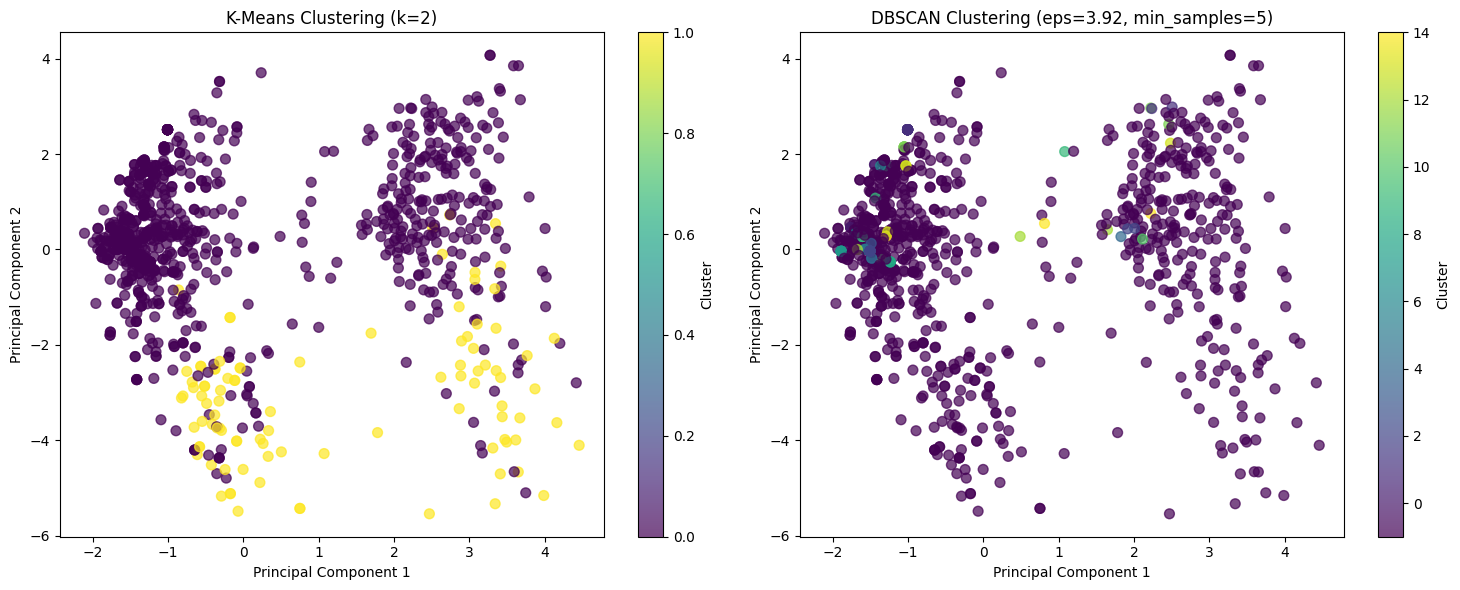

In [69]:
# 8. Visualization
# ---------------

# Apply PCA for visualization in 2D
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# Plot K-Means clusters
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], c=kmeans_labels,
                     cmap='viridis', s=50, alpha=0.7)
plt.title(f'K-Means Clustering (k={optimal_k})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster')

# Plot DBSCAN clusters
plt.subplot(1, 2, 2)
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], c=dbscan_labels,
                     cmap='viridis', s=50, alpha=0.7)
plt.title(f'DBSCAN Clustering (eps={optimal_eps:.2f}, min_samples=5)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster')

plt.tight_layout()
plt.show()

Identifying Potential Inappropriate claims

In [70]:
# Add cluster labels to original data
features_df['kmeans_cluster'] = kmeans_labels
features_df['dbscan_cluster'] = dbscan_labels

# Analyze features by cluster for K-Means
kmeans_cluster_analysis = features_df.groupby('kmeans_cluster').agg({
    'num_codes': ['mean', 'max', 'count'],
    'desc_similarity': ['mean', 'min', 'max'],
    'is_bilateral': ['mean'],
    'is_unilateral': ['mean'],
    'same_table': ['mean']
}).reset_index()

print("\nK-Means Cluster Analysis:")
print(kmeans_cluster_analysis)

# For DBSCAN: Analyze noise points (-1) vs. clustered points
print("\nDBSCAN Cluster Distribution:")
print(features_df['dbscan_cluster'].value_counts())

# Analyze noise points if there are any
if -1 in features_df['dbscan_cluster'].values:
    dbscan_noise_analysis = features_df[features_df['dbscan_cluster'] == -1].describe()
    print("\nDBSCAN Noise Points Analysis:")
    print(dbscan_noise_analysis[['num_codes', 'desc_similarity', 'is_bilateral', 'is_unilateral']])

# Find potentially inappropriate claims
def find_potential_inappropriate_claims(features_df, claims_df, df_tosp):
    """
    Identify potential inappropriate claims based on clustering results
    and domain-specific rules.
    """
    # Suspicious cases:
    # 1. Multiple codes with high description similarity
    # 2. Bilateral and unilateral codes together
    # 3. Codes from the same table that are very similar

    # For K-Means: Focus on clusters with high average number of codes
    kmeans_multi_code_clusters = features_df.groupby('kmeans_cluster')['num_codes'].mean()
    kmeans_target_clusters = kmeans_multi_code_clusters[kmeans_multi_code_clusters > 1.5].index.tolist()

    # For DBSCAN: Focus on noise points as potential anomalies
    dbscan_noise = features_df['dbscan_cluster'] == -1

    # Find suspicious claims
    suspicious_claims = features_df[
        (
            # Claims with multiple codes and high description similarity
            ((features_df['num_codes'] > 1) &
             (features_df['desc_similarity'] > 0.7))
            |
            # Claims in K-Means clusters associated with multiple codes
            ((features_df['kmeans_cluster'].isin(kmeans_target_clusters)) &
             (features_df['num_codes'] > 1))
            |
            # DBSCAN noise points with multiple codes
            (dbscan_noise & (features_df['num_codes'] > 1))
        )
    ]

    # Merge back with claim details for better analysis
    suspicious_with_details = pd.merge(
        suspicious_claims[['claim_id', 'num_codes', 'desc_similarity',
                          'kmeans_cluster', 'dbscan_cluster', 'original_codes']],
        claims_df[['claim_id', 'codes', 'descriptions']],
        on='claim_id'
    )

    # Add a suspicion score based on our heuristics
    suspicious_with_details['suspicion_score'] = (
        suspicious_with_details['desc_similarity'] * 0.6 +  # High similarity is suspicious
        (suspicious_with_details['num_codes'] > 1) * 0.4    # Multiple codes are suspicious
    )

    # Sort by suspicion score
    return suspicious_with_details.sort_values('suspicion_score', ascending=False)

# Find potential inappropriate claims
suspicious_claims = find_potential_inappropriate_claims(features_df, claims_df, df_tosp)
print("\nPotential Inappropriate Claims (Top 10):")
print(suspicious_claims[['claim_id', 'codes', 'descriptions',
                         'desc_similarity', 'kmeans_cluster',
                         'dbscan_cluster', 'suspicion_score']].head(10))


K-Means Cluster Analysis:
  kmeans_cluster num_codes           desc_similarity           is_bilateral  \
                      mean max count            mean  min  max         mean   
0              0  1.280973   2   904        0.737011  0.0  1.0     0.046460   
1              1  1.437500   2    96        0.590596  0.0  1.0     0.083333   

  is_unilateral same_table  
           mean       mean  
0      0.050885   0.735619  
1      0.062500   0.625000  

DBSCAN Cluster Distribution:
dbscan_cluster
-1     843
 2      47
 1      21
 9      12
 7       8
 8       8
 0       7
 4       7
 11      7
 10      6
 3       6
 13      6
 6       6
 14      6
 12      5
 5       5
Name: count, dtype: int64

DBSCAN Noise Points Analysis:
        num_codes  desc_similarity  is_bilateral  is_unilateral
count  843.000000       843.000000    843.000000     843.000000
mean     1.334520         0.686376      0.059312       0.061684
std      0.472102         0.445220      0.236348       0.240724
min   

Analysis

In [71]:
def analyze_cluster_features(kmeans_model, feature_names, numerical_feature_names):
    """Analyze which features are most important for each cluster."""
    # Get cluster centers
    centers = kmeans_model.cluster_centers_

    # Combine all feature names
    all_feature_names = list(feature_names) + numerical_feature_names

    # For each cluster, identify the top features
    for i in range(centers.shape[0]):
        print(f"\nCluster {i} Top Features:")

        # Sort features by absolute value of the center coordinate
        sorted_indices = np.argsort(np.abs(centers[i]))[::-1]

        # Print top 10 features
        for j in sorted_indices[:10]:
            print(f"  {all_feature_names[j]}: {centers[i][j]:.4f}")

# Define names for numerical features
numerical_feature_names = ['num_codes', 'is_bilateral', 'is_unilateral', 'same_table', 'desc_similarity']

# Analyze K-Means clusters
print("\nK-Means Cluster Feature Analysis:")


K-Means Cluster Feature Analysis:
